# Personalized cancer diagnosis

# 1. Business Problem

# 1.1. Description

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/

Data: Memorial Sloan Kettering Cancer Center (MSKCC)

Download training_variants.zip and training_text.zip from Kaggle.

Context:
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

Problem statement :
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

# 1.2. Source/Useful Links

Some articles and reference blogs about the problem statement

1. https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#2a44ee2f6b25
2. https://www.youtube.com/watch?v=UwbuW7oK8rk
3. https://www.youtube.com/watch?v=qxXRKVompI8

# 1.3. Real-world/Business objectives and constraints.

1.No low-latency requirement.
2.Interpretability is important.
3.Errors can be very costly.
4.Probability of a data-point belonging to each class is needed.

# 2. Machine Learning Problem Formulation

# 2.1. Data

# 2.1.1. Data Overview

1.Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
2.We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence   (text) that human experts/pathologists use to classify the genetic mutations.
3.Both these data files are have a common column called ID
4.Data file's information:
  training_variants (ID , Gene, Variations, Class)
  training_text (ID, Text)


# 2.1.2. Example Data Point

training_variants

ID,Gene,Variation,Class
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
...

training_text

ID,Text
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ...


# 2.2. Mapping the real-world problem to an ML problem

# 2.2.1. Type of Machine Learning Problem

There are nine different classes a genetic mutation can be classified into => Multi class classification problem

# 2.2.2. Performance Metric

Metric(s):

Multi class log-loss
Confusion matrix

# 2.2.3. Machine Learing Objectives and Constraints

Objective: Predict the probability of each data-point belonging to each of the nine classes.

Constraints:
* Interpretability * Class probabilities are needed. * Penalize the errors in class probabilites => Metric is Log-loss. * No Latency constraints.

# 2.3. Train, CV and Test Datasets

Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

# 3. Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


C:\Users\sourabh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# 3.1. Reading Data

# 3.1.1. Reading Gene and Variation Data

In [2]:
data = pd.read_csv('C:/Users/sourabh/Desktop/Cancer Diagnosis/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


training/training_variants is a comma separated file containing the description of the genetic mutations used for training.
Fields are

ID : the id of the row used to link the mutation to the clinical evidence
Gene : the gene where this genetic mutation is located
Variation : the aminoacid change for this mutations
Class : 1-9 the class this genetic mutation has been classified on

# 3.1.2. Reading Text Data

In [3]:
data_text =pd.read_csv("C:/Users/sourabh/Desktop/Cancer Diagnosis/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755


In [6]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [8]:
result.dropna(subset=['TEXT'], inplace=True)

In [9]:
result['TEXT'].isnull().sum()

0

# 3.1.3. Test, Train and Cross Validation Split

# 3.1.3.1. Splitting data into train, test and cross validation (64:20:16)

In [10]:
X = result.drop(['Class'],axis=1)

In [11]:
y = result['Class']

In [12]:
X_1, X_test, y_1, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_1' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, stratify=y_1, test_size=0.2)

In [13]:
print('Number of data points in train data:', y_train.shape[0])
print('Number of data points in test data:', y_test.shape[0])
print('Number of data points in cross validation data:', y_cv.shape[0])

Number of data points in train data: 2121
Number of data points in test data: 664
Number of data points in cross validation data: 531


# 3.1.3.2. Distribution of y_i's in Train, Test and Cross Validation datasets

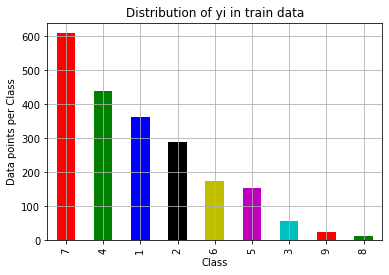

Number of data points in class 1 : 609 ( 28.713 %)
Number of data points in class 2 : 439 ( 20.698 %)
Number of data points in class 3 : 362 ( 17.067 %)
Number of data points in class 4 : 289 ( 13.626 %)
Number of data points in class 5 : 174 ( 8.204 %)
Number of data points in class 6 : 155 ( 7.308 %)
Number of data points in class 7 : 57 ( 2.687 %)
Number of data points in class 8 : 24 ( 1.132 %)
Number of data points in class 9 : 12 ( 0.566 %)
--------------------------------------------------------------------------------


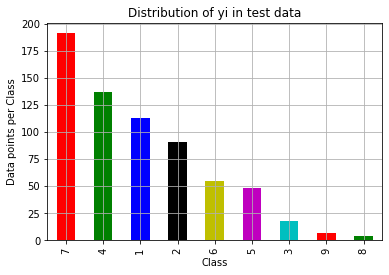

Number of data points in class 1 : 191 ( 28.765 %)
Number of data points in class 2 : 137 ( 20.633 %)
Number of data points in class 3 : 113 ( 17.018 %)
Number of data points in class 4 : 91 ( 13.705 %)
Number of data points in class 5 : 55 ( 8.283 %)
Number of data points in class 6 : 48 ( 7.229 %)
Number of data points in class 7 : 18 ( 2.711 %)
Number of data points in class 8 : 7 ( 1.054 %)
Number of data points in class 9 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


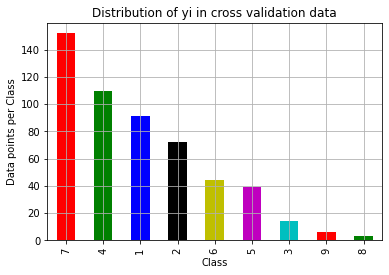

Number of data points in class 1 : 152 ( 28.625 %)
Number of data points in class 2 : 110 ( 20.716 %)
Number of data points in class 3 : 91 ( 17.137 %)
Number of data points in class 4 : 72 ( 13.559 %)
Number of data points in class 5 : 44 ( 8.286 %)
Number of data points in class 6 : 39 ( 7.345 %)
Number of data points in class 7 : 14 ( 2.637 %)
Number of data points in class 8 : 6 ( 1.13 %)
Number of data points in class 9 : 3 ( 0.565 %)


In [14]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()
cv_class_distribution = y_cv.value_counts()

my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
test_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
cv_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')


# 3.2 Univariate Analysis

# 3.2.1 Univariate Analysis on Gene Feature

Q1. Gene, What type of feature it is ?

Ans. Gene is a categorical variable

Q2. How many categories are there and How they are distributed?

In [15]:
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 229
BRCA1     155
TP53      104
EGFR       96
PTEN       79
BRCA2      76
KIT        65
BRAF       64
ERBB2      43
PIK3CA     39
ALK        38
Name: Gene, dtype: int64


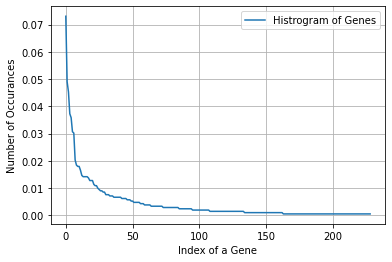

In [16]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

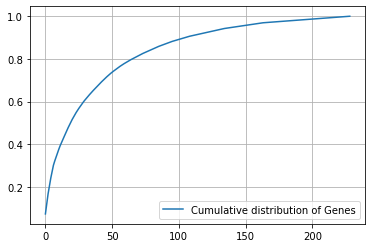

In [17]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Q3. How to featurize this Gene feature ?

Ans.One hot Encoding

In [18]:
gene_vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=1000)
X_train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
X_test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
X_cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

In [19]:
X_train['Gene'].head(10)

390       TP53
2878     BRCA2
2492     BRCA1
682     CDKN2A
534      SMAD2
2639     BRCA1
2481     BRCA1
2034    MAP2K2
1545       ALK
124      SF3B1
Name: Gene, dtype: object

In [20]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bcl10',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxo1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'ikzf1',
 'il7r',
 'inpp4b',
 'jak1',
 'jak2',
 'jun',
 'kdm5c',
 'kdm6a',
 'k

In [21]:
print("X_train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", X_train_gene_feature_onehotCoding.shape)

X_train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2121, 229)


Q4. How good is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  0.0001 The log loss is: 1.20551370185189
For values of alpha =  0.001 The log loss is: 1.2235780937525127
For values of alpha =  0.01 The log loss is: 1.3117474660572506
For values of alpha =  0.1 The log loss is: 1.4109644566488735
For values of alpha =  1 The log loss is: 1.4508173323157099


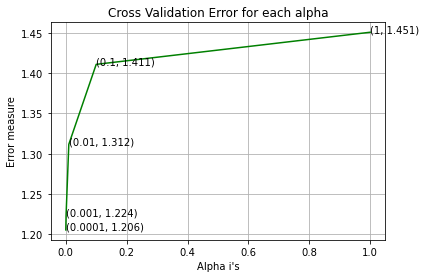

For values of best alpha =  0.0001 The train log loss is: 0.9895412732188061
For values of best alpha =  0.0001 The cross validation log loss is: 1.20551370185189
For values of best alpha =  0.0001 The test log loss is: 1.186312529179792


In [22]:
alpha = [10 ** x for x in range(-4, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_gene_feature_onehotCoding, y_train)
    y_predict = sig_clf.predict_proba(X_cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_gene_feature_onehotCoding, y_train)

y_predict = sig_clf.predict_proba(X_train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predict, labels=clf.classes_, eps=1e-15))

Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

# 3.2.2 Univariate Analysis on Variation Feature

Q6. Variation, What type of feature is it ?

Ans. Variation is a categorical variable

Q7. How many categories are there?

In [23]:
unique_variations = X_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1931
Truncating Mutations    55
Deletion                52
Amplification           42
Fusions                 18
Overexpression           4
T58I                     3
Q61H                     3
S222D                    2
E17K                     2
G12V                     2
Name: Variation, dtype: int64


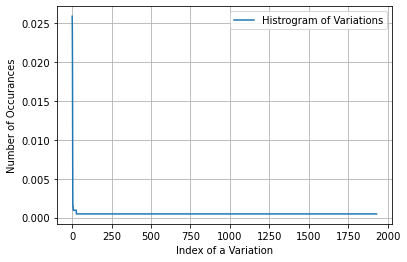

In [24]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02593116 0.0504479  0.07024988 ... 0.99905705 0.99952852 1.        ]


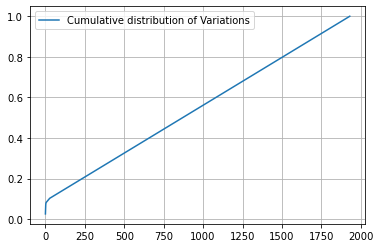

In [25]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [26]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=1000)
X_train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
X_test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
X_cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])

In [27]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", X_train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2121, 1000)


In [28]:
variation_vectorizer.get_feature_names()

['17',
 '19',
 '20',
 '20 insertions',
 'alk',
 'alk fusion',
 'amplification',
 'atf7ip',
 'bcor',
 'bcr',
 'binding',
 'binding domain',
 'braf',
 'braf fusion',
 'c618r',
 'cep85l',
 'deletion',
 'deletions',
 'dna',
 'dna binding',
 'domain',
 'e17k',
 'egfr',
 'ep300',
 'erg',
 'erg fusion',
 'etv6',
 'ewsr1',
 'exon',
 'exon 19',
 'exon 20',
 'exon mutations',
 'f28l',
 'f384l',
 'fgfr1',
 'fgfr1 fusion',
 'fgfr2',
 'fgfr3',
 'flt3',
 'fusion',
 'fusions',
 'g12c',
 'g12s',
 'g12v',
 'g13c',
 'g13v',
 'g35r',
 'g67r',
 'i31m',
 'igh',
 'insertion',
 'insertions',
 'jak2',
 'jak2 fusion',
 'kif5b',
 'l617m',
 'l622h',
 'l63f',
 'l63v',
 'l64p',
 'l668f',
 'l67p',
 'l692f',
 'l702h',
 'l703p',
 'l704n',
 'l708p',
 'l726f',
 'l726i',
 'l747_a750delinsp',
 'l747_p753delinss',
 'l747_t751del',
 'l747_t751delinsp',
 'l747f',
 'l747p',
 'l747s',
 'l749p',
 'l783f',
 'l78t',
 'l826p',
 'l830r',
 'l833v',
 'l838p',
 'l838v',
 'l858r',
 'l861p',
 'l861q',
 'l861r',
 'l910p',
 'l915m',
 'l9

Q8. How good is this Variation feature in predicting y_i?

Let's build a model just like the earlier!

For values of alpha =  0.0001 The log loss is: 1.7005745913518109
For values of alpha =  0.001 The log loss is: 1.7028221537224635
For values of alpha =  0.01 The log loss is: 1.7128639256044875
For values of alpha =  0.1 The log loss is: 1.7306959284050216
For values of alpha =  1 The log loss is: 1.732443480053852


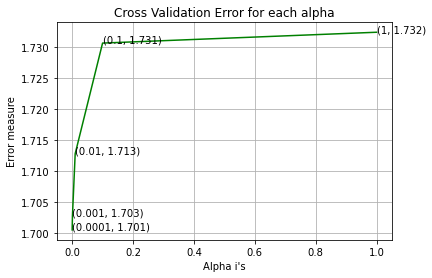

For values of best alpha =  0.0001 The train log loss is: 1.2059079351095463
For values of best alpha =  0.0001 The cross validation log loss is: 1.7005745913518109
For values of best alpha =  0.0001 The test log loss is: 1.6699616575753549


In [29]:
alpha = [10 ** x for x in range(-4, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_variation_feature_onehotCoding, y_train)
    y_predict = sig_clf.predict_proba(X_cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_variation_feature_onehotCoding, y_train)

y_predict = sig_clf.predict_proba(X_train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predict, labels=clf.classes_, eps=1e-15))


Q11. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Not sure! 

# 3.2.3 Univariate Analysis on Text Feature

In [30]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3,max_features=1000)
X_train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
X_train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
X_train_text_fea_counts = X_train_text_feature_onehotCoding.sum(axis=0).A1

In [31]:
print("Total number of unique words in train data :", len(X_train_text_features))

Total number of unique words in train data : 1000


In [32]:
X_train_text_feature_onehotCoding = normalize(X_train_text_feature_onehotCoding, axis=0)

X_test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
X_test_text_feature_onehotCoding = normalize(X_test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
X_cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
X_cv_text_feature_onehotCoding = normalize(X_cv_text_feature_onehotCoding, axis=0)

For values of alpha =  0.0001 The log loss is: 1.1439022483795698
For values of alpha =  0.001 The log loss is: 1.4058655549773276
For values of alpha =  0.01 The log loss is: 1.8828162604812233
For values of alpha =  0.1 The log loss is: 2.0390335238621606
For values of alpha =  1 The log loss is: 2.0227277818257936


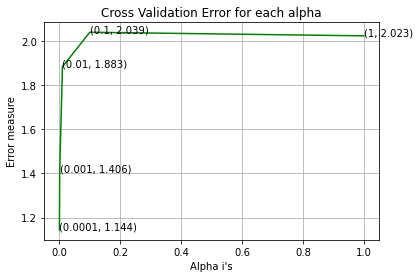

For values of best alpha =  0.0001 The train log loss is: 0.8101025876146426
For values of best alpha =  0.0001 The cross validation log loss is: 1.1439022483795698
For values of best alpha =  0.0001 The test log loss is: 1.1326575972496944


In [33]:
# Train a Logistic regression+Calibration model using text features which are on-hot encoded
alpha = [10 ** x for x in range(-4, 1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_text_feature_onehotCoding, y_train)
    y_predict = sig_clf.predict_proba(X_cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_text_feature_onehotCoding, y_train)

y_predict = sig_clf.predict_proba(X_train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predict, labels=clf.classes_, eps=1e-15))

Q. Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it seems like!

# 4. Machine Learning Models

In [34]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict(X_test)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(y_test, sig_clf.predict_proba(X_test)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((y_pred- y_test))/y_test.shape[0])

In [35]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(y_test, y_predict):
    C = confusion_matrix(y_test, y_predict)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [36]:
# merging gene, variance and text features

train_gene_var_onehotCoding = hstack((X_train_gene_feature_onehotCoding,X_train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((X_test_gene_feature_onehotCoding,X_test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((X_cv_gene_feature_onehotCoding,X_cv_variation_feature_onehotCoding))

X_train_onehotCoding = hstack((train_gene_var_onehotCoding, X_train_text_feature_onehotCoding)).tocsr()
y_train = np.array(list(y_train))

X_test_onehotCoding = hstack((test_gene_var_onehotCoding, X_test_text_feature_onehotCoding)).tocsr()
y_test = np.array(list(y_test))

X_cv_onehotCoding = hstack((cv_gene_var_onehotCoding, X_cv_text_feature_onehotCoding)).tocsr()
y_cv= np.array(list(y_cv))


In [37]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", X_train_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", X_test_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", X_cv_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2121, 2229)
(number of data points * number of features) in test data =  (664, 2229)
(number of data points * number of features) in cross validation data = (531, 2229)


# 4.1. Base Line Model

# 4.1.1. Naive Bayes

# 4.1.1.1. Hyper parameter tuning

for alpha = 0.0001
Log Loss : 1.156560855000807
for alpha = 0.001
Log Loss : 1.1531755293124728
for alpha = 0.1
Log Loss : 1.1710245632761531
for alpha = 1
Log Loss : 1.2038831560605079
for alpha = 10
Log Loss : 1.3693061201061871
for alpha = 100
Log Loss : 1.3770924600674148


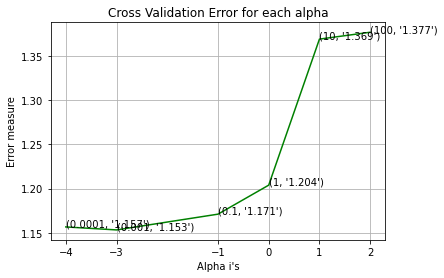

For values of best alpha =  0.001 The train log loss is: 0.735782099437973
For values of best alpha =  0.001 The cross validation log loss is: 1.1531755293124728
For values of best alpha =  0.001 The test log loss is: 1.1319022921865756


In [38]:
alpha = [0.0001, 0.001, 0.1, 1, 10, 100]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf1 = MultinomialNB(alpha=alpha[best_alpha])
clf1.fit(X_train_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf.fit(X_train_onehotCoding, y_train)


y_predict = sig_clf.predict_proba(X_train_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_cv_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_test_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predict, labels=clf.classes_, eps=1e-15))

# 4.1.1.2. Testing the model with best hyper paramters

In [39]:
print("Log loss :",log_loss(y_test, sig_clf.predict_proba(X_test_onehotCoding)))
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((sig_clf.predict(X_test_onehotCoding)- y_test))/y_test.shape[0])


Log loss : 1.1319022921865756
Number of mis-classified points : 0.35843373493975905


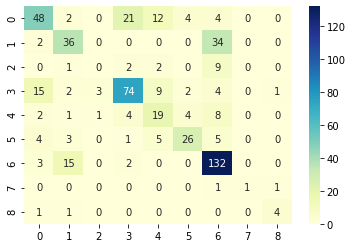

In [40]:
report = confusion_matrix(y_cv,sig_clf.predict(X_cv_onehotCoding))
heat_map = sns.heatmap(report,annot=True, fmt="d",cmap="YlGnBu")

# 4.2. Logistic Regression

# 4.2.1. With Class balancing

# 4.2.1.1. Hyper paramter tuning

for alpha = 0.0001
Log Loss : 1.0102606143544963
for alpha = 0.001
Log Loss : 1.0361129433588598
for alpha = 0.01
Log Loss : 1.1826696849105747
for alpha = 0.1
Log Loss : 1.68669444035362
for alpha = 1
Log Loss : 1.8364412067106737
for alpha = 10
Log Loss : 1.8519802278811186


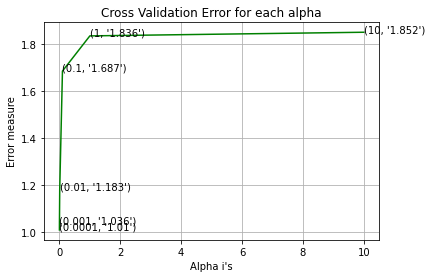

For values of best alpha =  0.0001 The train log loss is: 0.5481728987474296
For values of best alpha =  0.0001 The cross validation log loss is: 1.0102606143544963
For values of best alpha =  0.0001 The test log loss is: 0.9826425446453589


In [41]:
alpha = [10 ** x for x in range(-4, 2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf2 = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf2.fit(X_train_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf2, method="sigmoid")
sig_clf.fit(X_train_onehotCoding, y_train)

y_predict = sig_clf.predict_proba(X_train_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_cv_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_test_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predict, labels=clf.classes_, eps=1e-15))

In [42]:
print("Log Loss :",log_loss(y_test, sig_clf.predict_proba(X_test_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_test_onehotCoding)- y_test))/y_test.shape[0])

Log Loss : 0.9826425446453589
Number of missclassified point : 0.3253012048192771


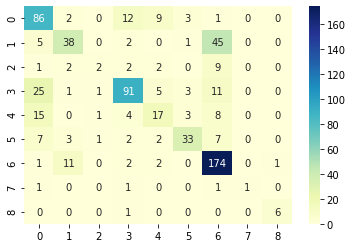

In [43]:
report = confusion_matrix(y_test,sig_clf.predict(X_test_onehotCoding))
heat_map = sns.heatmap(report,annot=True, fmt="d",cmap="YlGnBu")

# 4.2.2. Without Class balancing

# 4.2.2.1. Hyper paramter tuning

for alpha = 0.0001
Log Loss : 1.0365433733580276
for alpha = 0.001
Log Loss : 1.0995722397240424
for alpha = 0.01
Log Loss : 1.3472088533326816
for alpha = 0.1
Log Loss : 1.732699497349552
for alpha = 1
Log Loss : 1.8571164881593676
for alpha = 10
Log Loss : 1.8723803887219301


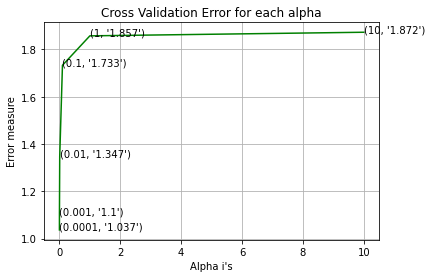

For values of best alpha =  0.0001 The train log loss is: 0.5406531389538823
For values of best alpha =  0.0001 The cross validation log loss is: 1.0365433733580276
For values of best alpha =  0.0001 The test log loss is: 1.000116742888095


In [44]:
alpha = [10 ** x for x in range(-4, 2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf3 = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf3.fit(X_train_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf3, method="sigmoid")
sig_clf.fit(X_train_onehotCoding, y_train)

y_predict = sig_clf.predict_proba(X_train_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_cv_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_test_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predict, labels=clf.classes_, eps=1e-15))

In [45]:
print("Log Loss :",log_loss(y_test, sig_clf.predict_proba(X_test_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_test_onehotCoding)- y_test))/y_test.shape[0])

Log Loss : 1.000116742888095
Number of missclassified point : 0.32680722891566266


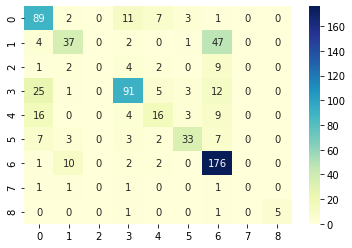

In [46]:
report = confusion_matrix(y_test,sig_clf.predict(X_test_onehotCoding))
heat_map = sns.heatmap(report,annot=True, fmt="d",cmap="YlGnBu")

# 4.3. Linear Support Vector Machines

# 4.3.1. Hyper paramter tuning

for alpha = 0.0001
Log Loss : 1.1100212141531907
for alpha = 0.001
Log Loss : 1.1153040599686503
for alpha = 0.01
Log Loss : 1.3932736256279907
for alpha = 0.1
Log Loss : 1.7032726098484483
for alpha = 1
Log Loss : 1.854315187110786
for alpha = 10
Log Loss : 1.8543161743197567


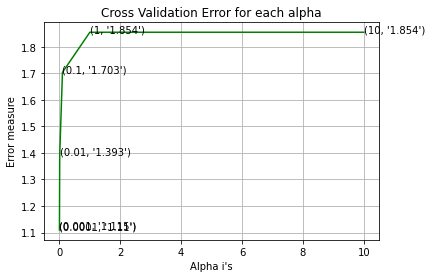

For values of best alpha =  0.0001 The train log loss is: 0.5644207433714966
For values of best alpha =  0.0001 The cross validation log loss is: 1.1100212141531907
For values of best alpha =  0.0001 The test log loss is: 1.0899700453408159


In [47]:
alpha = [10 ** x for x in range(-4, 2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf4 = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf4.fit(X_train_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf4, method="sigmoid")
sig_clf.fit(X_train_onehotCoding, y_train)

y_predict = sig_clf.predict_proba(X_train_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_cv_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, y_predict, labels=clf.classes_, eps=1e-15))
y_predict = sig_clf.predict_proba(X_test_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_predict, labels=clf.classes_, eps=1e-15))

In [48]:
print("Log Loss :",log_loss(y_test, sig_clf.predict_proba(X_test_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_test_onehotCoding)- y_test))/y_test.shape[0])

Log Loss : 1.0899700453408159
Number of missclassified point : 0.338855421686747


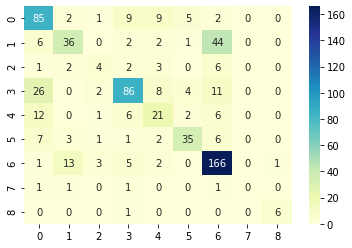

In [49]:
report = confusion_matrix(y_test,sig_clf.predict(X_test_onehotCoding))
heat_map = sns.heatmap(report,annot=True, fmt="d",cmap="YlGnBu")

# Conclusion

Logistic Regression with class balancing is the best model for this problem